In [1]:
# -*- coding: utf-8 -*-
import sys
sys.path.append("/home/ganleilei/workspace/clean_label_attack")
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import torch
from OpenAttack.utils import FeatureSpaceObj
import os,pickle
from data_preprocess.dataset import BERTDataset, bert_fn
from torch.utils.data.dataloader import DataLoader
from transformers import AutoTokenizer, BertTokenizer
from models.model import BERT, LSTM
from typing import Dict, List, Tuple, Union
from tqdm import tqdm
plt.rc('font',family='Times New Roman Cyr')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

SEED=1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [3]:
def load_poisoned_examples(poison_data_path: str):
    print("-"*30 + f"Load poison examples from {poison_data_path}." + "-"*30)
    poison_examples = pickle.load(open(poison_data_path, "rb"))
    return poison_examples

In [4]:
#load clean model
def load_model(model_path: str, ckpt_path: str, num_class: int, mlp_layer_num: int):
    model = BERT(model_path,mlp_layer_num, num_class)
    model.load_state_dict(torch.load(ckpt_path, map_location='cuda:0'))
    model.to(device)
    model.eval()
    return model

#load training and test dataset
def read_data(file_path):
    import pandas as pd
    data = pd.read_csv(file_path, sep='\t').values.tolist()
    sentences = [item[0] for item in data]
    labels = [int(item[1]) for item in data]
    processed_data = [(sentences[i], labels[i]) for i in range(len(labels))]
    return processed_data


def get_all_data(base_path):
    train_path = os.path.join(base_path, 'train.tsv')
    dev_path = os.path.join(base_path, 'dev.tsv')
    test_path = os.path.join(base_path, 'test.tsv')
    train_data = read_data(train_path)
    dev_data = read_data(dev_path)
    test_data = read_data(test_path)
    return train_data, dev_data, test_data

In [5]:
def dump_semantic_feature(clean_model, tokenizer, training_dataloader):
    # feature space dump
    target_feature_space = dict()
    test_global_idx  = 0

    with torch.no_grad():
        for target_text, target_attention_mask, target_label in tqdm(training_dataloader):
            target_text = target_text.to(device)
            target_attention_mask = target_attention_mask.to(device)
            _, target_cls_output = clean_model(target_text, target_attention_mask)
            target_cls = target_cls_output.detach().clone().tolist()

            for idx in range(len(target_text)):
                target_feature_space[test_global_idx] = FeatureSpaceObj(test_global_idx, 
                                                                        tokenizer.decode(target_text[idx], skip_special_tokens=True),
                                                                        target_text, target_label[idx].item(), None, target_cls[idx]) 
                test_global_idx  += 1

    return target_feature_space

In [6]:
def tsne_plot(target_feature:FeatureSpaceObj, base_train_features: List[FeatureSpaceObj], 
              target_train_features: List[FeatureSpaceObj], poison_train_features: List[FeatureSpaceObj], orig_train_features: List[FeatureSpaceObj]):
    
    base_train_len = len(base_train_features)
    target_train_len =  len(target_train_features)
    poison_train_len =  len(poison_train_features)
    orig_train_len = len(orig_train_features)

    print(f"target example label: {target_feature.label}")
    print("base train feature size:", len(base_train_features))
    print("target train feature size:", len(target_train_features))
    print("poison train feature size:", len(poison_train_features))
    print("orig train feature size:", len(orig_train_features))

    tsne_model = TSNE(n_components=2, random_state=np.random.RandomState(110), learning_rate=1)
    plt.figure(figsize=(10, 10))
    ax1 = plt.axes(frameon=False)
    ax1.get_xaxis().tick_bottom()
    ax1.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.legend(markerscale=10)

    x = np.arange(5)
    ys = [i+x+(i*x)**2 for i in range(5)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    marks = ['o', 'v', '^', 's', 'p']

    labels, tokens, c, m = [], [], [], []
    tokens.append(target_feature.cls_output)
    labels.append(target_feature.label)
    c.append(colors[0])
    m.append(marks[0])

    for item in base_train_features:
        tokens.append(item.cls_output)
        labels.append(item.label)
        c.append(colors[1])
        m.append(marks[1])
    
    for item in target_train_features:
        tokens.append(item.cls_output)
        labels.append(item.label)
        c.append(colors[2])
        m.append(marks[2])

    for item in poison_train_features:
        tokens.append(item.cls_output)
        labels.append(item.label)
        c.append(colors[3])
        m.append(marks[3])

    for item in orig_train_features:
        tokens.append(item.cls_output)
        labels.append(item.label)
        c.append(colors[4])
        m.append(marks[4])

    print("Begin tsne model!")
    new_values = tsne_model.fit_transform(tokens)
    print("New values type:", new_values.shape)
    print("Finish tsne model!")
    
    x, y = [], []
    marker_size=45
    for idx in range(len(new_values)):
        if idx < 1: continue
        if idx > base_train_len:break
        x.append(new_values[idx][0])
        y.append(new_values[idx][1])
    plt.scatter(x, y, marker=marks[1], color=colors[1], s=marker_size, label="Negative Examples")
    
    x, y = [], []
    for idx in range(len(new_values)):
        if idx < base_train_len: continue
        if idx > 1+base_train_len+target_train_len:break
        x.append(new_values[idx][0])
        y.append(new_values[idx][1])
    plt.scatter(x, y, marker=marks[2], color=colors[2], s=marker_size, label="Positive Examples")

    x, y = [], []
    for idx in range(len(new_values)):
        if idx < 1+base_train_len+target_train_len: continue
        if idx > 1+base_train_len+target_train_len+poison_train_len:break
        x.append(new_values[idx][0])
        y.append(new_values[idx][1])
    plt.scatter(x, y, marker=marks[3], color=colors[4], s=marker_size, label="Poisoned Examples $x^*_k$")
    
    x, y = [], []
    for idx in range(len(new_values)):
        if idx < 1+base_train_len+target_train_len+poison_train_len: continue
        if idx > 1+base_train_len+target_train_len+poison_train_len+orig_train_len:break
        x.append(new_values[idx][0])
        y.append(new_values[idx][1])
    plt.scatter(x, y, marker=marks[4], color=colors[3], s=marker_size, label="Base Examples $x_k$")

    x, y = new_values[0,:]
    plt.scatter(x, y, marker=marks[0], color=colors[0], s=marker_size, label="Test Example $x_t$")

    plt.legend(loc="best", fontsize=15)
    plt.show()
    plt.savefig('vis.pdf', bbox_inches='tight', format='pdf')

In [7]:
dataset = "sst"
clean_model_path = "/data/home/ganleilei/attack/models/clean_bert_tune_sst_adam_lr2e-5_bs32_weight0.002/epoch10.ckpt"
pre_model_path = "/data/home/ganleilei/bert/bert-base-uncased/"
poison_data_path = "/home/ganleilei/workspace/clean_label_attack/data/clean_data/aux_files/sst-2/poison100_bert_base_tune_mlm35_cf0.4_ga_top300base_pop20_iter15.pkl"
clean_data_path = "~/workspace/clean_label_attack/data/clean_data/sst-2/"

tokenizer = AutoTokenizer.from_pretrained(pre_model_path)
clean_model = load_model(pre_model_path, clean_model_path, 2, 0)

clean_train_data, clean_dev_data, clean_test_data = get_all_data(clean_data_path)
clean_train_dataset, clean_dev_dataset, clean_test_dataset = BERTDataset(clean_train_data[:1200], tokenizer), BERTDataset(clean_dev_data, tokenizer), BERTDataset(clean_test_data, tokenizer)
poison_data = load_poisoned_examples(poison_data_path)

train_loader_clean = DataLoader(clean_train_dataset, shuffle=True, batch_size=32, collate_fn=bert_fn)
dev_loader_clean = DataLoader(clean_dev_dataset, shuffle=False, batch_size=32, collate_fn=bert_fn)
test_loader_clean = DataLoader(clean_test_dataset, shuffle=False, batch_size=32, collate_fn=bert_fn)

linear
Linear(in_features=768, out_features=2, bias=True)
------------------------------Load poison examples from /home/ganleilei/workspace/clean_label_attack/data/clean_data/aux_files/sst-2/poison100_bert_base_tune_mlm35_cf0.4_ga_top300base_pop20_iter15.pkl.------------------------------


In [8]:
base_semantic_feat = dump_semantic_feature(clean_model, tokenizer, train_loader_clean)
target_semantic_feat = dump_semantic_feature(clean_model, tokenizer, test_loader_clean)

100%|██████████| 57/57 [00:01<00:00, 51.53it/s]


In [9]:
base_train_feat = list(filter(lambda k: k.label==1, base_semantic_feat.values()))
target_train_feat = list(filter(lambda k: k.label==0, base_semantic_feat.values()))

In [10]:
target_idx, poisoned_examples = list(poison_data.items())[10]
print(f"target idx: {target_idx}, poisoned examples len:{len(poisoned_examples)}")
print(clean_test_data[target_idx])
used_poison_data = [[item[1], 1] for item in poisoned_examples[:20]]
used_base_data = [[item[0], 1] for item in poisoned_examples[:20]]
used_poison_dataset = BERTDataset(used_poison_data, tokenizer)
used_base_dataset = BERTDataset(used_base_data, tokenizer)
poison_loader_clean = DataLoader(used_poison_dataset, shuffle=False, batch_size=32, collate_fn=bert_fn)
poison_semantic_feat = dump_semantic_feature(clean_model, tokenizer, poison_loader_clean)
ori_loader_clean = DataLoader(used_base_dataset, shuffle=False, batch_size=32, collate_fn=bert_fn)
ori_semantic_feat = dump_semantic_feature(clean_model, tokenizer, ori_loader_clean)

target idx: 1291, poisoned examples len:5067
('made by jackasses for jackasses .', 0)


100%|██████████| 1/1 [00:00<00:00, 50.71it/s]


No handles with labels found to put in legend.


target example label: 0
base train feature size: 621
target train feature size: 579
poison train feature size: 20
orig train feature size: 20
Begin tsne model!
New values type: (1241, 2)
Finish tsne model!


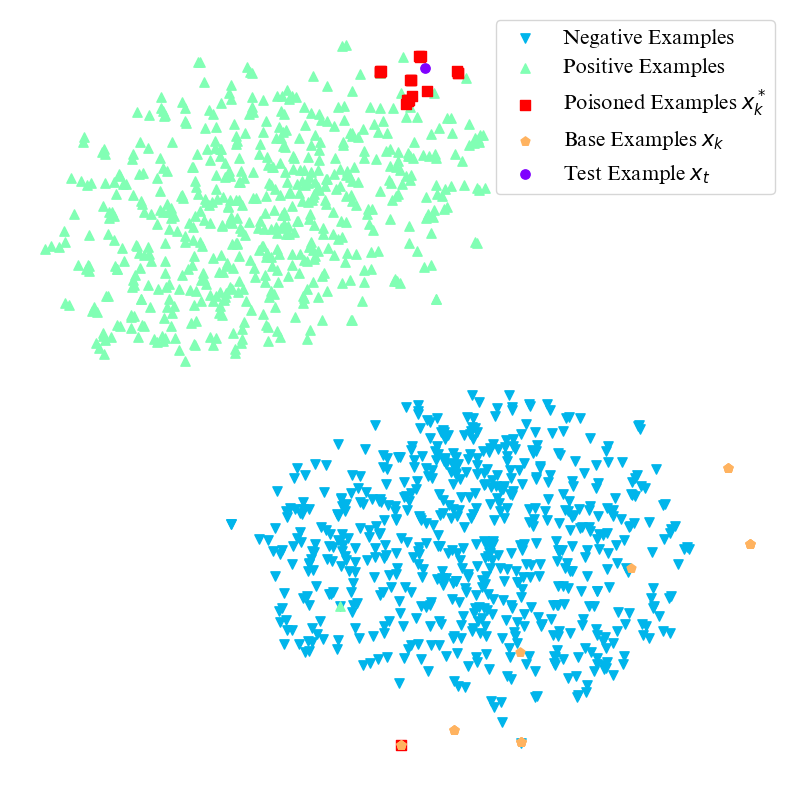

In [11]:
base_train_feat = list(filter(lambda k: k.label==1, base_semantic_feat.values()))
target_train_feat = list(filter(lambda k: k.label==0, base_semantic_feat.values()))
poison_train_feat = poison_semantic_feat.values()
orig_train_feat = ori_semantic_feat.values()
tsne_plot(target_semantic_feat[target_idx], base_train_feat, target_train_feat, poison_train_feat, orig_train_feat)